In [1]:
%matplotlib inline


분류기(Classifier) 학습하기
===========================

지금까지 어떻게 신경망을 정의하고, 손실을 계산하며 또 가중치를 갱신하는지에
대해서 배웠습니다.

이제 아마도 이런 생각을 하고 계실텐데요,

데이터는 어떻게 하나요?
------------------------

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰텐데요, 이러한 데이터는
표준 Python 패키지를 사용하여 불러온 후 NumPy 배열로 변환하면 됩니다.
그리고 그 배열을 ``torch.*Tensor`` 로 변환하면 됩니다.

-  이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
-  텍스트의 경우에는 그냥 Python이나 Cython의 것들을 사용하거나, NLTK나 SpaCy도
   좋습니다.

특별히 영상 분야를 위해서는 ``torchvision`` 이라는 패키지를 만들어두었는데요,
여기에는 Imagenet이나 CIFAR10, MNIST 등과 같은 일반적으로 사용하는 데이터셋을
불러오는 함수들(data loaders)이나, image, viz., ``torchvision.datasets`` 와
``torch.utils.data.DataLoader`` 데이터 변환기가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서
작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용할 텐데요, 여기에는 다음과 같은 분류들이
있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.
그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32인데요, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)로 이뤄져 있다는 뜻입니다.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


이미지 분류기 학습하기
----------------------------

다음의 단계로 진행해보겠습니다:

1. CIFAR10의 학습용 / 시험(test)용 데이터셋을 ``torchvision`` 을 사용하여
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

1. CIFAR10를 불러오고 정규화하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

``torchvision`` 을 사용하면 매우 쉽게 CIFAR10 데이터를 불러올 수 있습니다.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환하겠습니다.



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


재미삼아 학습용 이미지 몇 개를 보겠습니다.



 bird plane  ship truck


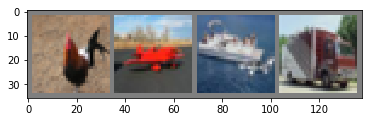

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. 합성곱 신경망(Convolution Neural Network) 정의하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
이전에 배웠던 신경망 섹션에서 신경망을 복사하고, (기존에 1채널 이미지만 처리하던
것 대신) 3채널 이미지를 처리할 수 있도록 수정합니다.



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. 손실 함수와 Optimizer 정의하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
이제, 분류에 대한 교차 엔트로피 손실(Cross-Entropy loss)과 momentum을 갖는
SGD를 사용합니다.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. 신경망 학습하기
^^^^^^^^^^^^^^^^^^^^

이제부터 흥미로우실 겁니다.
데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면 됩니다.



In [8]:
for epoch in range(2):  # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.634
[1,  4000] loss: 1.550
[1,  6000] loss: 1.471
[1,  8000] loss: 1.410
[1, 10000] loss: 1.398
[1, 12000] loss: 1.351
[2,  2000] loss: 1.291
[2,  4000] loss: 1.257
[2,  6000] loss: 1.250
[2,  8000] loss: 1.274
[2, 10000] loss: 1.237
[2, 12000] loss: 1.239
Finished Training


5. 시험용 데이터로 신경망 검사하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

학습용 데이터셋을 2회 반복하여 신경망을 학습시켰는데요, 신경망이 전혀 배운게
없을지도 모르니 확인해보겠습니다.

신경망이 예측한 정답과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인할텐데요,
예측이 맞다면 샘플을 '맞은 예측값(Correct predictions)'에 넣겠습니다.

먼저 시험용 데이터를 좀 보겠습니다.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

좋습니다, 이제 신경망이 어떻게 예측했는지를 보죠:



In [ ]:
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 더 해당 분류에 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

(10가지 분류에서 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

자, 이제 다음은 뭘까요?

이러한 신경망들을 GPU에서 실행한다면 어떨까요?

GPU에서 학습하기
----------------
Tensor를 GPU로 옮겼던 것처럼, 신경망을 GPU로 옮길 수 있습니다.

먼저, CUDA를 사용할 수 있는 경우 첫번째 CUDA 장치(Device)를 사용하도록 설정합니다:



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기 상에서 돌린다고 가정하면, 이와 같이 하면 CUDA 장치를 출력합니다:

print(device)

이 섹션의 남머지에서는 `device` 를 CUDA 장치라고 가정하겠습니다.

그리고 이 메소드(Method)들은 재귀적으로 모든 모듈로 가서 매개변수와 버퍼를
CUDA tensor로 변경합니다:

.. code:: python

    net.to(device)


모든 단계에서 입력(input)과 정답(target)도 GPU로 보내야 한다는 것도 기억하셔야
합니다:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

CPU와 비교했을 때 어마어마한 속도 차이가 나지 않는 것은 왜 그럴까요?
그 이유는 바로 신경망이 너무 작기 때문입니다.

**Exercise:** 신경망의 크기를 키웠을 때 얼마나 빨라지는지 확인해보세요.
(첫번째 ``nn.Conv2d`` 의 2번째 매개변수와 두번째 ``nn.Conv2d`` 의 1번째
매개변수는 같아야 합니다.)

**목표를 달성했습니다**:

- 높은 수준에서 PyTorch의 Tensor library와 신경망를 이해합니다.
- 이미지를 분류하는 작은 신경망을 학습시킵니다.

여러개의 GPU에서 학습하기
-------------------------
모든 GPU를 활용해서 더욱 더 속도를 올리고 싶다면, :doc:`data_parallel_tutorial` 을 참고하세요.

이제 뭘 해볼까요?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `다른 예제들 참고하기`_
-  `더 많은 튜토리얼 보기`_
-  `포럼에서 PyTorch에 대해 얘기하기`_
-  `Slack에서 다른 사용자와 대화하기`_


